# Sentiment analysis of movie reviews

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Descripcíon de los Datos

Campos seleccionados:

* __`review`__: el texto de la reseña

* __`pos`__: el objetivo, '0' para negativo y '1' para positivo

* __`ds_part`__: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
# Cargar Database y convertir a DataFrame
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

# Mostrar primeros registros
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [5]:
# Información del DataFrame
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

Observamos que las columnas objetivo no contienen valores nulos.

In [6]:
# Verificar duplicados para la columna reviews
df_reviews['review'].duplicated().sum()

91

No necesariamente una mismo texto de reseña es un duplicado, dos usuarios podrían coincidir en las palabras de una reseña (sobre todo si es muy simple) y realizar calificaciones distintas.

## EDA

### Número de películas y reseñas a lo largo de los años.

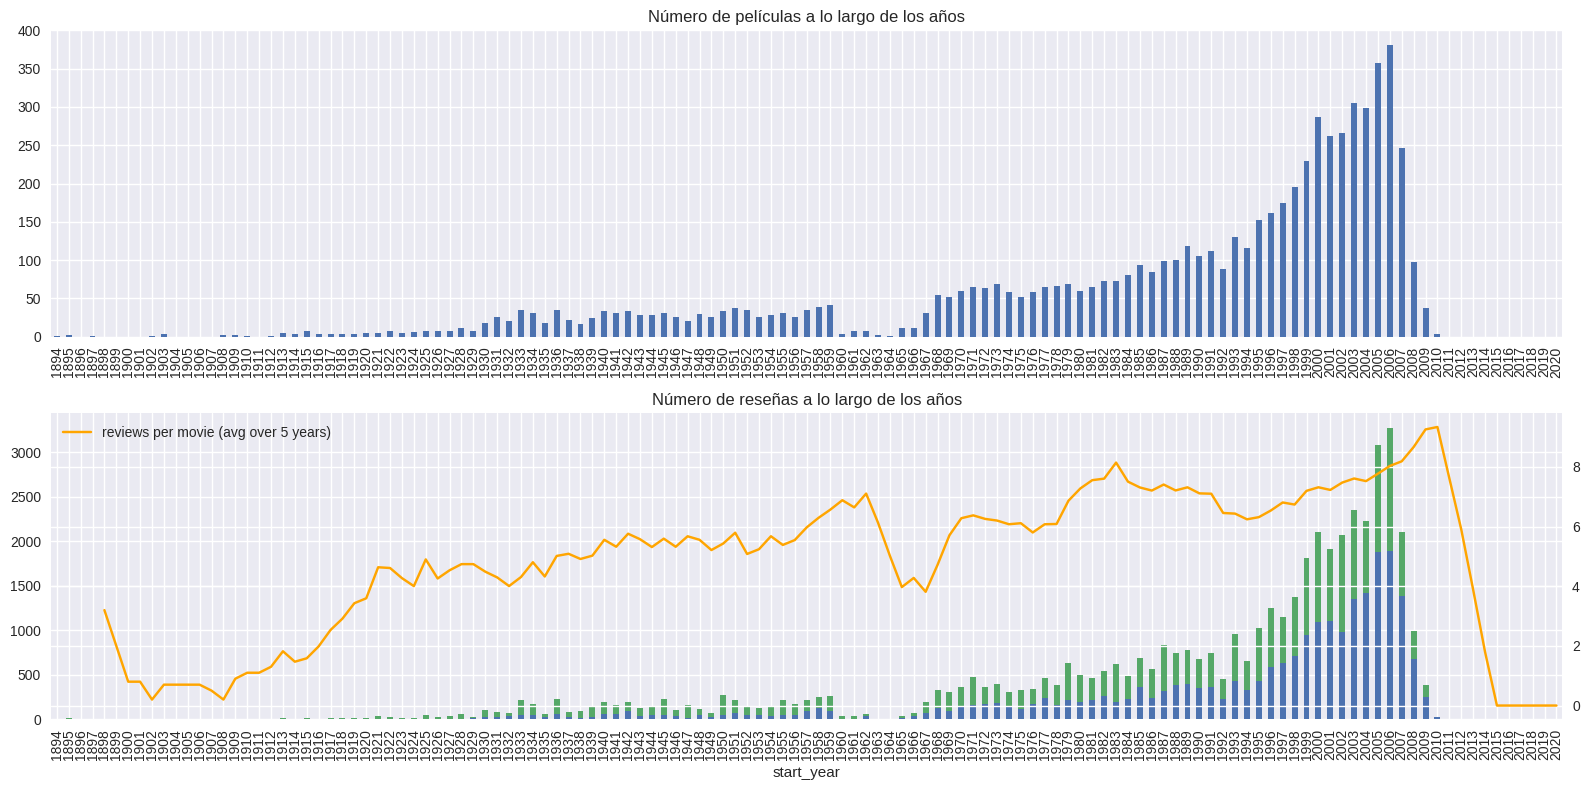

In [7]:
# Crear subplots para dos gráficos verticales
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Gráfico 1: Número de películas por año
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)  # Rellenar años sin datos
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

# Gráfico 2: Número de reseñas por año (positivas y negativas) + promedio de reseñas por película
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack().reindex(
    np.arange(dft1.index.min(), max(dft1.index.max(), 2021)), fill_value=0)  # Rellenar años sin datos
dft2.plot(kind='bar', stacked=True, ax=ax)  # Reseñas por año (apilado)
dft3 = df_reviews['start_year'].value_counts().reindex(np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft3 = (dft3 / dft1).fillna(0)  # Promedio de reseñas por película

# Añadir gráfico de promedio de reseñas por película
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# Añadir leyendas combinadas
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
ax.set_title('Número de reseñas a lo largo de los años')

# Ajustar diseño
fig.tight_layout()

* `Aumento en la producción de películas`: El número de películas ha aumentado considerablemente desde la década de 1960 hasta los años 2000, lo que refleja un aumento en la producción cinematográfica.
<br>

* `Más reseñas por película`: A medida que más películas fueron lanzadas, el número de reseñas por película también aumentó, alcanzando un pico alrededor de 2010. Esto puede estar relacionado con la mayor accesibilidad a plataformas en línea que permiten a los usuarios escribir reseñas.
<br>

* `Disminución actual`: Tanto el número de películas como el número de reseñas han disminuido drásticamente después de 2015, lo que probablemente se deba a la falta de datos recientes.

### Distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

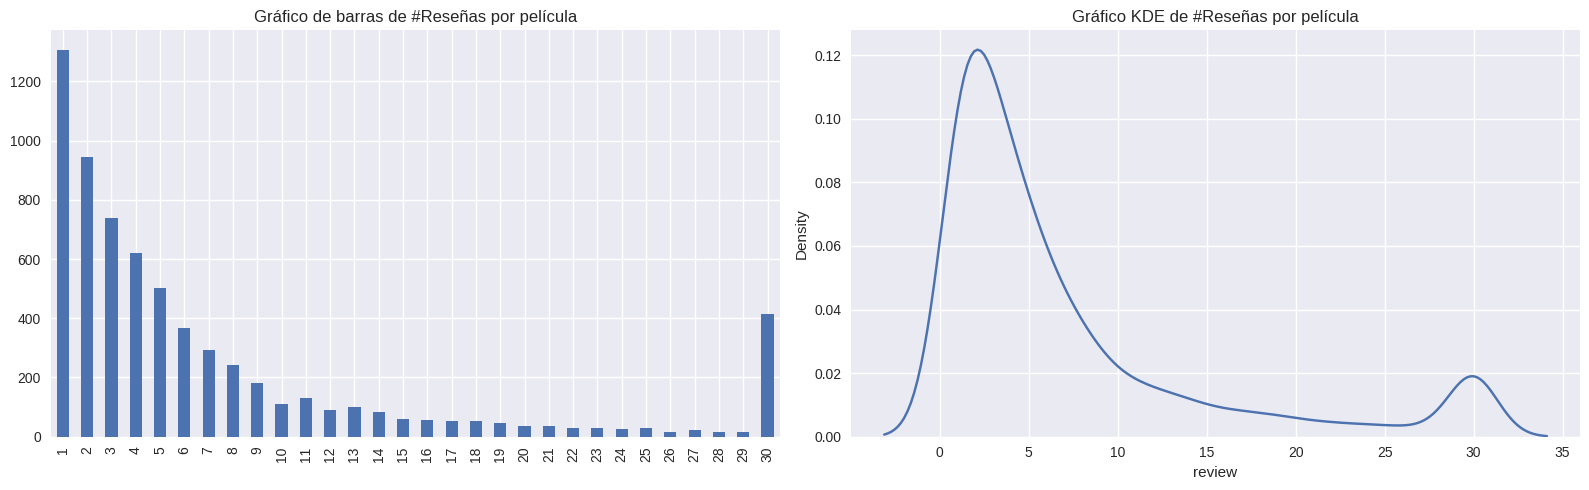

In [8]:
# Crear subplots para dos gráficos horizontales
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Gráfico de barras de cantidad de reseñas por película
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()  # Contar reseñas por película y agrupar
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

# Gráfico 2: KDE de la distribución de reseñas por película
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()  # Contar reseñas por película
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

# Ajustar diseño
fig.tight_layout()

`Películas con pocas reseñas`: La mayoría de las películas en este conjunto de datos tienen muy pocas reseñas, lo cual podría afectar el análisis de sentimientos o la representación de las películas en un sistema de recomendación.

`Investigación adicional`: El pico en las películas con 30 reseñas puede ser un patrón interesante o una irregularidad que vale la pena explorar para entender si hay una razón detrás de este comportamiento (por ejemplo, algún tipo de limitación o criterio en el conjunto de datos).

In [9]:
# Balance de clases para la variable objetivo
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Las clases están casi equilibradas, con una diferencia mínima entre reseñas negativas y positivas. Esto es positivo para el modelado, ya que un balance de clases adecuado evita problemas como el sesgo del modelo hacia una clase dominante.

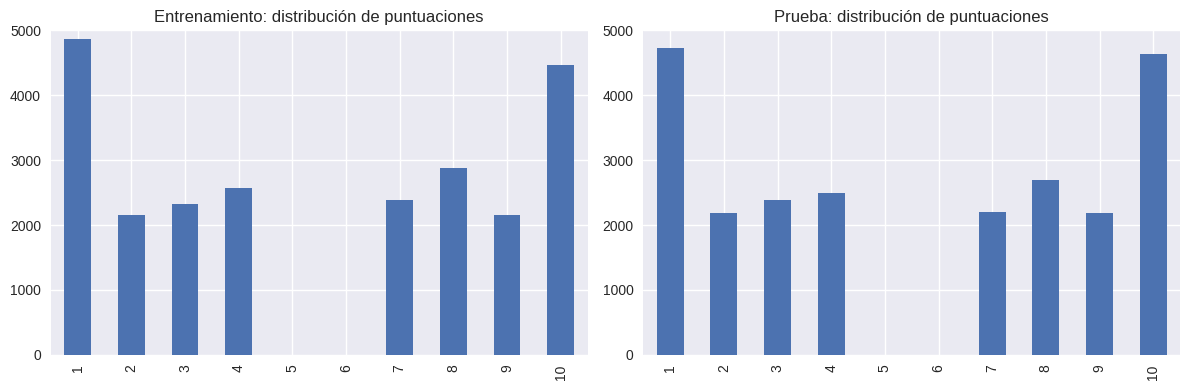

In [10]:
# Crear subplots para comparar las distribuciones de puntuaciones en entrenamiento y prueba
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1: Conjunto de entrenamiento
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(1, 11)).fillna(0)  # Asegurar rango de 1 a 10 y rellenar faltantes
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])  # Mismo límite en Y para ambos gráficos
ax.set_title('Entrenamiento: distribución de puntuaciones')

# Gráfico 2: Conjunto de prueba
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(1, 11)).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Prueba: distribución de puntuaciones')

# Ajustar diseño
fig.tight_layout()

Ambos conjuntos de datos parecen estar equilibrados en cuanto a la distribución de las puntuaciones. La concentración en los extremos (1 y 10) sugiere que los usuarios tienden a calificar películas de manera polarizada (muy negativa o muy positiva), lo cual puede influir en el entrenamiento y rendimiento del modelo.

### Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


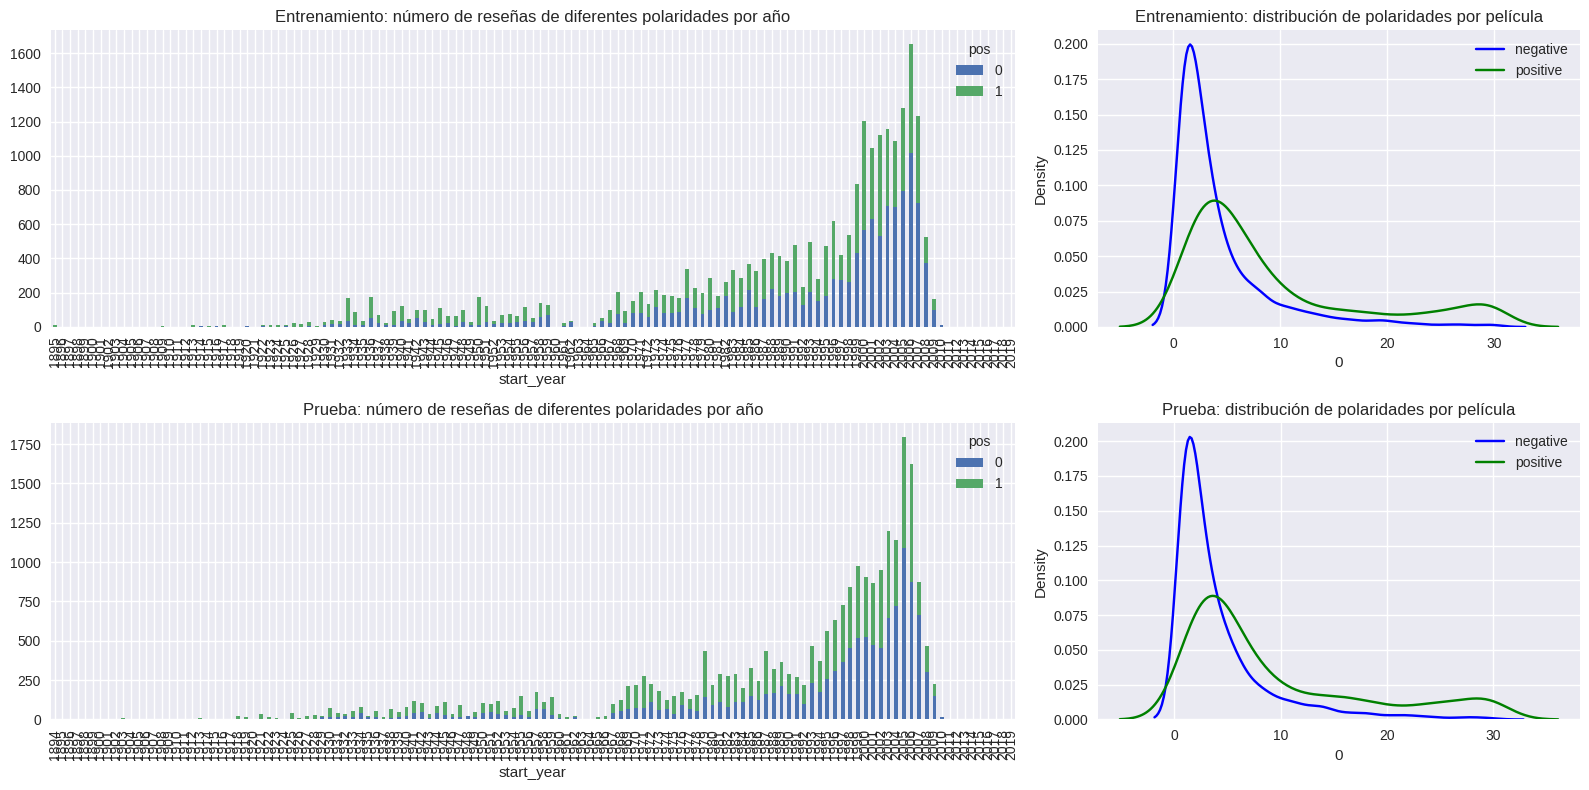

In [11]:
# Crear subplots con 2 filas y 2 columnas, ajustando las proporciones de ancho y alto
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Gráfico 1: Reseñas por polaridad a lo largo de los años en el conjunto de entrenamiento
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Entrenamiento: número de reseñas de diferentes polaridades por año')

# Gráfico 2: Distribución de polaridades por película en el conjunto de entrenamiento (KDE)
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Entrenamiento: distribución de polaridades por película')

# Gráfico 3: Reseñas por polaridad a lo largo de los años en el conjunto de prueba
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Prueba: número de reseñas de diferentes polaridades por año')

# Gráfico 4: Distribución de polaridades por película en el conjunto de prueba (KDE)
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Prueba: distribución de polaridades por película')

# Ajustar el diseño
fig.tight_layout()

* `Aumento de reseñas con el tiempo`: Tanto en el conjunto de entrenamiento como en el de prueba, el número de reseñas (positivas y negativas) ha aumentado drásticamente desde los años 1980.
<br>

* `Predominio de reseñas negativas en años recientes`: A partir de 2010, parece haber una leve inclinación hacia un mayor número de reseñas negativas en ambos conjuntos.
<br>

* `Distribución polarizada`: En cuanto a la distribución de polaridades por película, la mayoría de las películas tienen pocas reseñas negativas, mientras que las positivas muestran una mayor variación en cantidad de reseñas, lo que sugiere que las reseñas negativas tienden a ser más frecuentes pero concentradas en menos películas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Crear subplots para F1, ROC y PRC

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
        pred_target = model.predict(features)  # Predicciones binarias
        pred_proba = model.predict_proba(features)[:, 1]  # Probabilidad de clase positiva
        
        # Calcular F1 en diferentes umbrales
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # Calcular ROC y AUC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # Calcular PRC y APS
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        # Configurar color según el conjunto de datos (train o test)
        color = 'blue' if type == 'train' else 'green'

        # Gráfico de F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Añadir marcadores en puntos clave
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title('Valor F1')

        # Gráfico de ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # Añadir marcadores en puntos clave
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea de referencia
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title('Curva ROC')

        # Gráfico de PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        
        # Añadir marcadores en puntos clave
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title('PRC')

        # Guardar métricas clave
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    # Mostrar métricas como DataFrame
    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [13]:
import os
import re
import nltk

# Especificar un directorio temporal o alguno en el que tengas permisos
download_dir = '/tmp/nltk_data'
nltk.download('stopwords', download_dir=download_dir)

# Configurar la variable de entorno NLTK_DATA para que apunte al nuevo directorio
os.environ['NLTK_DATA'] = download_dir

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /tmp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def normalize_review(text):
    # Convertir a minúsculas, eliminar signos de puntuación y dígitos
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar normalización a las reseñas
df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_review)

  0%|          | 0/47331 [00:00<?, ?it/s]

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [17]:
# Vectorizar las reseñas normalizadas
tfidf_vectorizer_1 = TfidfVectorizer(max_features=5000)
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

In [18]:
# Entrenar el modelo de Regresión Logística
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000)

           train  test
Exactitud   0.92  0.88
F1          0.92  0.88
APS         0.97  0.95
ROC AUC     0.97  0.95


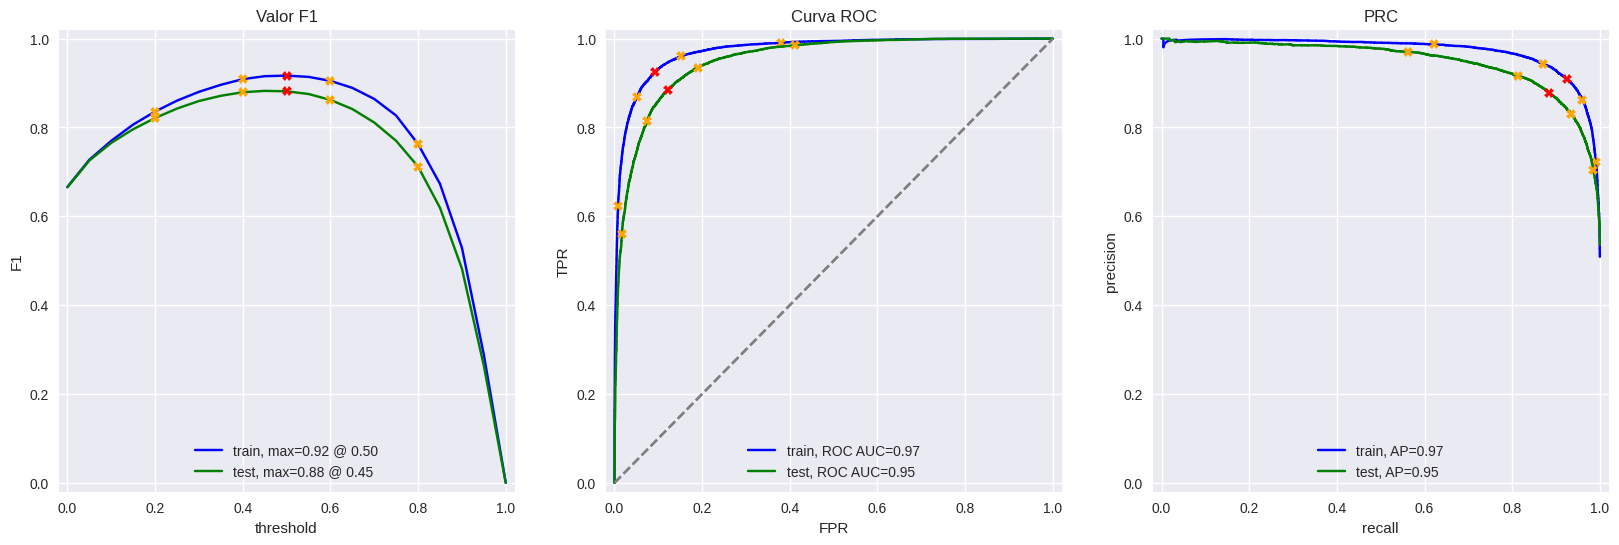

In [19]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

El modelo muestra un excelente rendimiento en todas las métricas clave, tanto en el conjunto de entrenamiento como en el de prueba. El `F1` de `0.88` en el conjunto de prueba cumple con el objetivo del proyecto de alcanzar al menos `0.85`, y las otras métricas refuerzan la solidez del modelo.

### Modelo 2 - spaCy, TF-IDF y LR

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [21]:
def text_preprocessing_2(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [22]:
# Preprocesar las reseñas con spaCy
df_reviews['review_spacy'] = df_reviews['review_norm'].progress_apply(text_preprocessing_2)

  0%|          | 0/47331 [00:00<?, ?it/s]

In [23]:
# Dividir el DataFrame en entrenamiento y prueba incluyendo la columna 'review_spacy'
df_reviews_train = df_reviews[df_reviews['ds_part'] == 'train'][['review_spacy', 'pos']].copy()
df_reviews_test = df_reviews[df_reviews['ds_part'] == 'test'][['review_spacy', 'pos']].copy()

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizar las reseñas con TF-IDF
tfidf_vectorizer_2 = TfidfVectorizer(max_features=5000)
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_spacy'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_spacy'])

In [25]:
# Entrenar Regresión Logística
model_2 = LogisticRegression(max_iter=1000)
model_2.fit(train_features_2, train_target)

LogisticRegression(max_iter=1000)

           train  test
Exactitud   0.91  0.88
F1          0.91  0.88
APS         0.97  0.95
ROC AUC     0.97  0.95


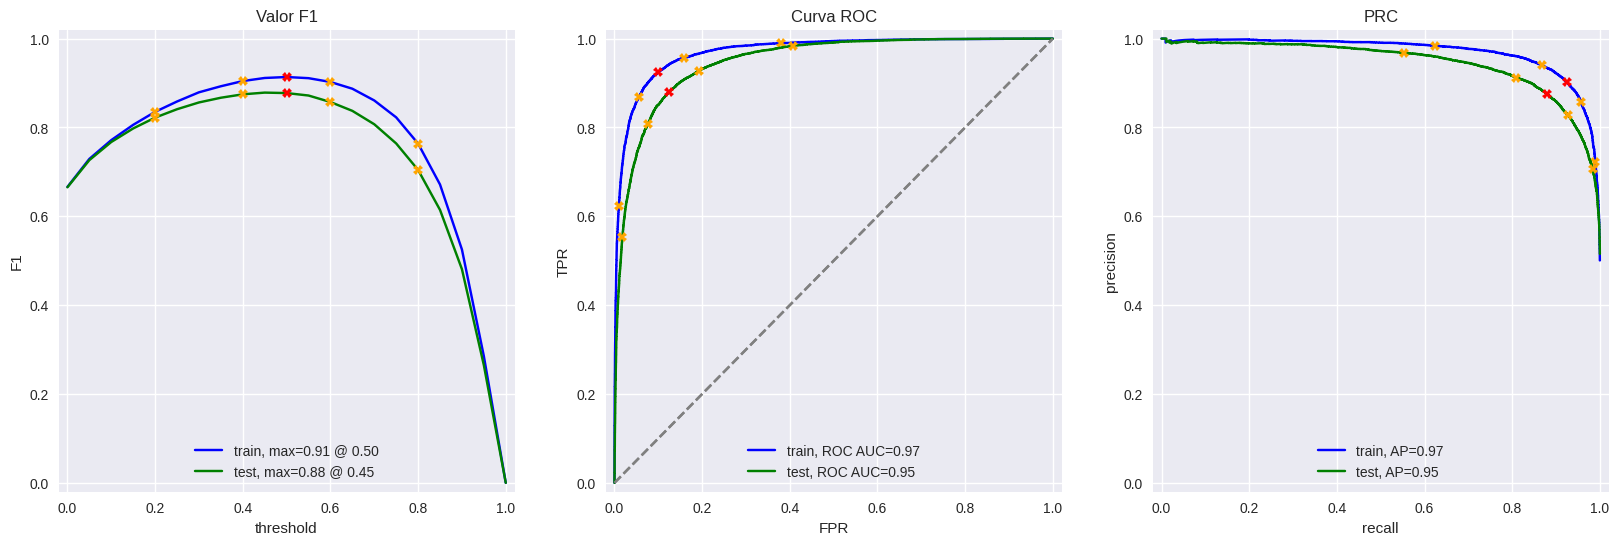

In [26]:
# Evaluar el modelo 2
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Este modelo, utilizando `spaCy` para el procesamiento del lenguaje natural, presenta un rendimiento casi idéntico al Modelo 1. La principal diferencia radica en el uso de lemmatización mediante spaCy, que parece no mejorar significativamente el rendimiento en este caso. Sin embargo, el modelo cumple con el objetivo de alcanzar un `F1-score` de al menos `0.85` en el conjunto de prueba.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [27]:
from lightgbm import LGBMClassifier

In [28]:
# Entrenar LGBMClassifier
model_3 = LGBMClassifier()
model_3.fit(train_features_2, train_target)

LGBMClassifier()

           train  test
Exactitud   0.91  0.86
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.93


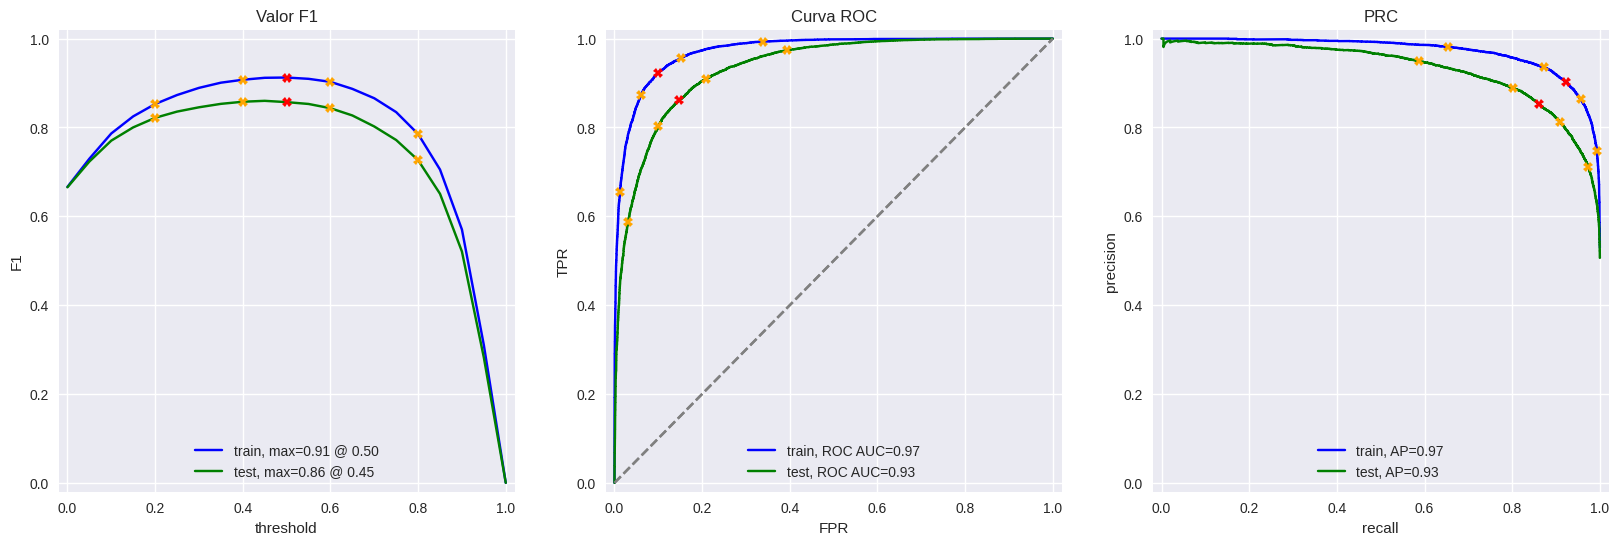

In [29]:
# Evaluar el modelo 3
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

El `Modelo 3`, que utiliza el clasificador `LGBM`, muestra un rendimiento muy bueno en términos de métricas, aunque con una ligera caída en el conjunto de prueba. Sin embargo, aún supera el objetivo del `F1-score` de `0.85`, y su capacidad de generalización sigue siendo adecuada.

## Mis reseñas

In [30]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

# Aplicar la misma lógica de normalización que para el conjunto de datos principal
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_review)

# Mostrar el DataFrame con las reseñas normalizadas
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie
2,I was really fascinated with the movie,really fascinated movie
3,Even the actors looked really old and disinter...,even actors looked really old disinterested go...
4,I didn't expect the reboot to be so good! Writ...,didnt expect reboot good writers really cared ...
5,"The movie had its upsides and downsides, but I...",movie upsides downsides feel like overall dece...
6,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke lands everyo...
7,Launching on Netflix was a brave move & I real...,launching netflix brave move really appreciate...


### Modelo 1

In [31]:
# Seleccionar las reseñas normalizadas de my_reviews
texts = my_reviews['review_norm']

# Predecir probabilidades utilizando el modelo 2 y el vectorizador TF-IDF entrenado
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

# Mostrar las predicciones de probabilidad junto con las primeras 100 letras de cada reseña
for i, review in enumerate(texts.str.slice(0, 100)):  # Slice de los primeros 100 caracteres de la reseña
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  simply like kind movie
0.16:  well bored felt asleep middle movie
0.60:  really fascinated movie
0.10:  even actors looked really old disinterested got paid movie soulless cash grab
0.21:  didnt expect reboot good writers really cared source material
0.54:  movie upsides downsides feel like overall decent flick could see going see
0.05:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.91:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Modelo 2

In [32]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.26:  simply like kind movie
0.14:  well bored felt asleep middle movie
0.62:  really fascinated movie
0.09:  even actors looked really old disinterested got paid movie soulless cash grab
0.16:  didnt expect reboot good writers really cared source material
0.50:  movie upsides downsides feel like overall decent flick could see going see
0.07:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.96:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Modelo 3

In [33]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = tfidf_vectorizer_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.61:  simply like kind movie
0.44:  well bored felt asleep middle movie
0.68:  really fascinated movie
0.46:  even actors looked really old disinterested got paid movie soulless cash grab
0.46:  didnt expect reboot good writers really cared source material
0.69:  movie upsides downsides feel like overall decent flick could see going see
0.25:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.82:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


## Conclusiones

* __`Mejor Modelo`__:

Los `Modelos 1 y 2`, que usan Regresión Logística, se destacaron por su rendimiento consistente tanto en el conjunto de entrenamiento como en el de prueba. Ambos modelos alcanzan el umbral de F1-score de 0.85 en el conjunto de prueba, con una ligera ventaja para el Modelo 1 en el conjunto de entrenamiento.

`Modelo 3`, aunque robusto, tiene un `F1-score` más bajo en el conjunto de prueba (0.86), lo que sugiere que no generaliza tan bien como los otros dos modelos.

* __`Recomendación`__:

Para esta tarea de clasificación, el `Modelo 1` (NLTK, TF-IDF y Regresión Logística) parece ser la mejor opción. Muestra un buen equilibrio entre las métricas de entrenamiento y prueba, con un rendimiento estable y menos riesgo de sobreajuste.

__`Conclusiones sobre las reseñas`__:

* El `Modelo 1` tiende a ser más conservador en sus predicciones, con probabilidades más bajas para las reseñas menos entusiastas, y una alta probabilidad solo para la reseña positiva más clara (reseña 8).
<br>

* El `Modelo 2`, usando `spaCy`, muestra un comportamiento similar al Modelo 1, pero con una ligera variación en las probabilidades, manteniendo la clasificación similar.
<br>

* El `Modelo 3`, con `LGBMClassifier`, muestra probabilidades más altas en general, con algunas reseñas más negativas clasificadas más cercanas al umbral de la positividad, lo que podría ser indicativo de una menor capacidad para separar las reseñas claramente negativas.

__`Recomendación`__:

* Los `Modelos 1 y 2` (basados en Regresión Logística) muestran resultados más consistentes y conservadores, lo que puede ser ventajoso para evitar falsos positivos en la clasificación de reseñas negativas.
<br>

* `Modelo 3` tiene una mayor variación en las probabilidades y tiende a clasificar algunas reseñas negativas con mayor positividad, lo que podría afectar la precisión general del sistema de recomendación.